In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np 
import matplotlib.pyplot as plt
import functions as f
import cv2
from classes import Discriminator, Generator, weights_init
from PIL import Image

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
#Inititate constants
PROCESS_DATA = 1 #Change to 1 when training
TRAINING_DATA = 1 #Change to 1 if want model to be trained again

In [4]:
#Inititate constants
BATCH_SIZE = 64
IMG_SIZE = 64

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [6]:
if PROCESS_DATA:
    dataset = datasets.FashionMNIST("data",train = True,transform=data_transform,download = True)
    trainloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers = 4, shuffle=True)

In [7]:
#Show training data size
print(len(dataset))

60000


In [8]:
#Show training labels
LABELS = dataset.classes
print(LABELS)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


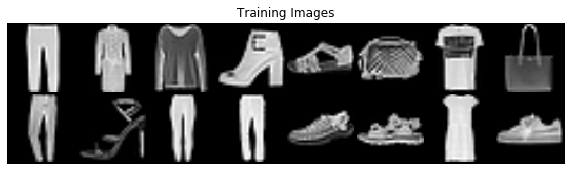

In [9]:
#Visualize some data samples
def visualize_samples(NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(10,10))
    img = next(iter(trainloader))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(img[0][a:a+NUM_PIC],padding=2, normalize=True),(1,2,0)))
    plt.show()

visualize_samples(16)

In [10]:
LATENT_SIZE = 100

In [11]:
#Make latent vector by creating random Gaussian noise
def random_noise(size):
    noise = torch.randn(size,LATENT_SIZE,1,1)
    noise = Variable(noise).to(device)
    return noise

In [12]:
#Generate labels for loss fuction
def generate_labels(size, label):
    if label:
        data = torch.ones(size,1)-0.1
    else:
        data = torch.zeros(size,1)
    data = Variable(data).view(-1).to(device)
    return data

In [13]:
#Inititate weights for Generator and Discriminator with mean = 0.02, standard deviation = 1
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128*8,4,1,0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*8,128*4,4,2,1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*4,128*2,4,2,1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*2,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,1,4,2,1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [15]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1,128,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace= True),

            nn.Conv2d(128,128*2,4,2,1, bias=False),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2, inplace= True),

            nn.Conv2d(128*2,128*4,4,2,1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2, inplace= True),

            nn.Conv2d(128*4,128*8,4,2,1, bias=False),
            nn.BatchNorm2d(128*8),
            nn.LeakyReLU(0.2, inplace= True),

            nn.Conv2d(128*8,1,4,1,0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
def train_discriminator(D, optimizer, error, real_data, fake_data):
    batch_size = real_data.size(0)
    optimizer.zero_grad()

    real_data = real_data.to(device)
    fake_data = fake_data.to(device)

    prediction_real = D(real_data).view(-1)
    real_label = generate_labels(batch_size,1)
    loss_real = error(prediction_real,real_label)
    loss_real.backward()

    prediction_fake = D(fake_data).view(-1)
    fake_label = generate_labels(batch_size,0)
    loss_fake = error(prediction_fake, fake_label)
    loss_fake.backward()

    D_x = prediction_real.mean().item()
    D_g_z1 = prediction_fake.mean().item()
    optimizer.step()

    return loss_real.data + loss_fake.data, D_x, D_g_z1

In [17]:
def train_generator(D, optimizer, error, data):
    batch_size = data.size(0)
    optimizer.zero_grad()
    data = data.to(device)
    prediction = D(data).view(-1)
    label = generate_labels(batch_size, 1)
    loss = error(prediction, label)
    loss.backward()
    D_g_z2 = prediction.mean().item()
    optimizer.step()
    return loss.data, D_g_z2

In [18]:
def generate_img(G,noise):
    G.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(10,10))
        test_img = G(noise).view(-1,1,IMG_SIZE,IMG_SIZE).data.cpu()
        img = np.transpose(torchvision.utils.make_grid(test_img[:],padding=2, normalize=True),(1,2,0))
        img = np.array(img)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()
    G.train()

In [19]:
#Generate latent vector
test_noise = random_noise(16)

In [20]:
def train(D, G, D_optimizer, G_optimizer, error, trainloader):
    EPOCHS = 5
    D_loss_list = []
    G_loss_list = []
    print("Start Training.....")
    for epoch in range(EPOCHS):
        for i, (real_batch,_) in enumerate(trainloader):  
            batch_size = real_batch.size(0)
            fake_data = G(random_noise(batch_size)).detach()
            real_data = Variable(real_batch.view(-1,1,IMG_SIZE,IMG_SIZE))
            D_loss,D_x, D_g_z1 = train_discriminator(D,D_optimizer,error,real_data,fake_data)
            data = G(random_noise(batch_size))
            G_loss, D_g_z2 = train_generator(D,G_optimizer,error,data)
            if i%50 == 0 :
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch,EPOCHS,i,len(trainloader),D_loss,G_loss,D_x, D_g_z1,D_g_z2))
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)   
        torch.save(G.state_dict(), "model/generator-dcgan3.pth")
        torch.save(D.state_dict(), "model/discriminator-dcgan3.pth")
        generate_img(G,test_noise)
    #plot(D_loss_list,G_loss_list,len(D_loss_list))
    return G, D_loss_list,G_loss_list

Start Training.....
Epoch: (0/5), Batch: (0/938), D_Loss: 2.5455, G_Loss: 13.6013, D(x): 0.6862, G(D(z)): 0.7677 / 0.0000
Epoch: (0/5), Batch: (50/938), D_Loss: 1.1786, G_Loss: 38.4345, D(x): 0.9997, G(D(z)): 0.0000 / 0.0000
Epoch: (0/5), Batch: (100/938), D_Loss: 1.0027, G_Loss: 3.4948, D(x): 0.6466, G(D(z)): 0.2203 / 0.0335
Epoch: (0/5), Batch: (150/938), D_Loss: 0.9363, G_Loss: 4.5535, D(x): 0.8580, G(D(z)): 0.2795 / 0.0366
Epoch: (0/5), Batch: (200/938), D_Loss: 0.8115, G_Loss: 4.3716, D(x): 0.9309, G(D(z)): 0.2581 / 0.0182
Epoch: (0/5), Batch: (250/938), D_Loss: 0.7516, G_Loss: 2.0094, D(x): 0.6875, G(D(z)): 0.1197 / 0.1667
Epoch: (0/5), Batch: (300/938), D_Loss: 0.6131, G_Loss: 2.7202, D(x): 0.7372, G(D(z)): 0.1217 / 0.0838
Epoch: (0/5), Batch: (350/938), D_Loss: 0.9362, G_Loss: 2.4553, D(x): 0.8173, G(D(z)): 0.3244 / 0.1366
Epoch: (0/5), Batch: (400/938), D_Loss: 0.8535, G_Loss: 2.8533, D(x): 0.6614, G(D(z)): 0.1094 / 0.0804
Epoch: (0/5), Batch: (450/938), D_Loss: 0.9611, G_Loss

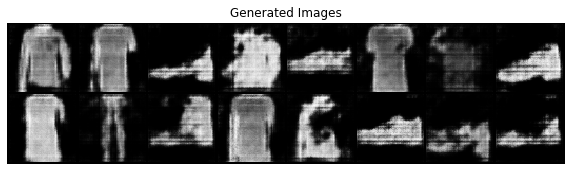

Epoch: (1/5), Batch: (0/938), D_Loss: 0.6615, G_Loss: 2.6136, D(x): 0.7087, G(D(z)): 0.1325 / 0.0886
Epoch: (1/5), Batch: (50/938), D_Loss: 0.8870, G_Loss: 4.4377, D(x): 0.9337, G(D(z)): 0.3676 / 0.0106
Epoch: (1/5), Batch: (100/938), D_Loss: 1.2322, G_Loss: 1.4790, D(x): 0.3681, G(D(z)): 0.0224 / 0.2913
Epoch: (1/5), Batch: (150/938), D_Loss: 1.9109, G_Loss: 4.3278, D(x): 0.9275, G(D(z)): 0.6516 / 0.0157
Epoch: (1/5), Batch: (200/938), D_Loss: 0.6686, G_Loss: 2.6424, D(x): 0.7402, G(D(z)): 0.1549 / 0.0755
Epoch: (1/5), Batch: (250/938), D_Loss: 0.6796, G_Loss: 2.3909, D(x): 0.6677, G(D(z)): 0.0966 / 0.1121
Epoch: (1/5), Batch: (300/938), D_Loss: 0.7301, G_Loss: 3.8451, D(x): 0.8038, G(D(z)): 0.2357 / 0.0284
Epoch: (1/5), Batch: (350/938), D_Loss: 0.6042, G_Loss: 3.3433, D(x): 0.7630, G(D(z)): 0.1060 / 0.0385
Epoch: (1/5), Batch: (400/938), D_Loss: 0.6492, G_Loss: 2.9449, D(x): 0.8617, G(D(z)): 0.1984 / 0.0574
Epoch: (1/5), Batch: (450/938), D_Loss: 0.6214, G_Loss: 2.9586, D(x): 0.8113

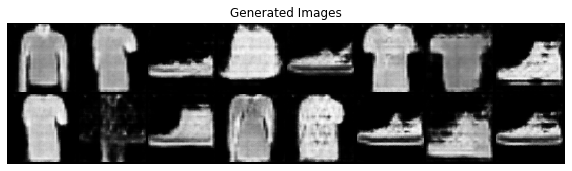

Epoch: (2/5), Batch: (0/938), D_Loss: 0.9094, G_Loss: 2.3879, D(x): 0.4875, G(D(z)): 0.0294 / 0.1374
Epoch: (2/5), Batch: (50/938), D_Loss: 0.6610, G_Loss: 2.8916, D(x): 0.7103, G(D(z)): 0.1378 / 0.0568
Epoch: (2/5), Batch: (100/938), D_Loss: 0.5317, G_Loss: 3.1879, D(x): 0.7654, G(D(z)): 0.0783 / 0.0476
Epoch: (2/5), Batch: (150/938), D_Loss: 0.5205, G_Loss: 4.2068, D(x): 0.7491, G(D(z)): 0.0131 / 0.0164
Epoch: (2/5), Batch: (200/938), D_Loss: 0.6957, G_Loss: 3.9475, D(x): 0.8170, G(D(z)): 0.2087 / 0.0254
Epoch: (2/5), Batch: (250/938), D_Loss: 1.1992, G_Loss: 1.1408, D(x): 0.3365, G(D(z)): 0.0292 / 0.4081
Epoch: (2/5), Batch: (300/938), D_Loss: 0.8504, G_Loss: 2.4571, D(x): 0.5487, G(D(z)): 0.0430 / 0.0982
Epoch: (2/5), Batch: (350/938), D_Loss: 0.6260, G_Loss: 1.9708, D(x): 0.6304, G(D(z)): 0.0532 / 0.1754
Epoch: (2/5), Batch: (400/938), D_Loss: 0.6995, G_Loss: 3.9696, D(x): 0.8279, G(D(z)): 0.2459 / 0.0180
Epoch: (2/5), Batch: (450/938), D_Loss: 0.4556, G_Loss: 3.4773, D(x): 0.8869

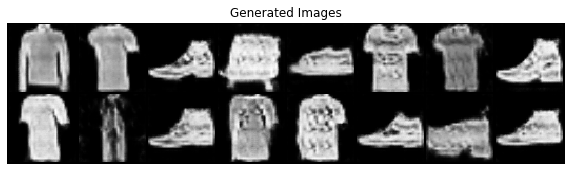

Epoch: (3/5), Batch: (0/938), D_Loss: 0.5050, G_Loss: 4.0993, D(x): 0.8714, G(D(z)): 0.0938 / 0.0214
Epoch: (3/5), Batch: (50/938), D_Loss: 0.4556, G_Loss: 3.4693, D(x): 0.9142, G(D(z)): 0.0764 / 0.0343
Epoch: (3/5), Batch: (100/938), D_Loss: 3.0275, G_Loss: 0.5586, D(x): 0.0571, G(D(z)): 0.0010 / 0.6698
Epoch: (3/5), Batch: (150/938), D_Loss: 0.4688, G_Loss: 2.9887, D(x): 0.8151, G(D(z)): 0.0722 / 0.0547
Epoch: (3/5), Batch: (200/938), D_Loss: 0.5657, G_Loss: 3.2105, D(x): 0.7682, G(D(z)): 0.1009 / 0.0493
Epoch: (3/5), Batch: (250/938), D_Loss: 0.8536, G_Loss: 1.5334, D(x): 0.4888, G(D(z)): 0.0126 / 0.3605
Epoch: (3/5), Batch: (300/938), D_Loss: 0.4026, G_Loss: 4.5840, D(x): 0.9187, G(D(z)): 0.0226 / 0.0090
Epoch: (3/5), Batch: (350/938), D_Loss: 0.5507, G_Loss: 2.8126, D(x): 0.7662, G(D(z)): 0.0623 / 0.0642
Epoch: (3/5), Batch: (400/938), D_Loss: 0.6163, G_Loss: 2.7810, D(x): 0.6105, G(D(z)): 0.0167 / 0.0835
Epoch: (3/5), Batch: (450/938), D_Loss: 0.4770, G_Loss: 3.6774, D(x): 0.8869

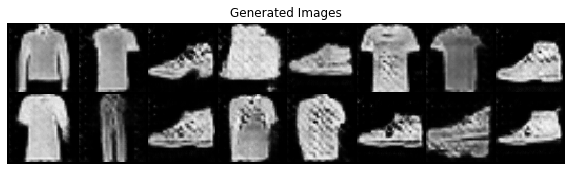

Epoch: (4/5), Batch: (0/938), D_Loss: 0.4605, G_Loss: 2.0297, D(x): 0.7556, G(D(z)): 0.0278 / 0.1441
Epoch: (4/5), Batch: (50/938), D_Loss: 0.6173, G_Loss: 5.1029, D(x): 0.9734, G(D(z)): 0.1602 / 0.0055
Epoch: (4/5), Batch: (100/938), D_Loss: 0.7277, G_Loss: 3.7258, D(x): 0.8351, G(D(z)): 0.2394 / 0.0395
Epoch: (4/5), Batch: (150/938), D_Loss: 0.4113, G_Loss: 3.8635, D(x): 0.9083, G(D(z)): 0.0536 / 0.0217
Epoch: (4/5), Batch: (200/938), D_Loss: 0.6061, G_Loss: 3.7093, D(x): 0.6457, G(D(z)): 0.0053 / 0.0316
Epoch: (4/5), Batch: (250/938), D_Loss: 0.6414, G_Loss: 3.7999, D(x): 0.8553, G(D(z)): 0.2126 / 0.0210
Epoch: (4/5), Batch: (300/938), D_Loss: 0.7222, G_Loss: 1.7814, D(x): 0.5319, G(D(z)): 0.0044 / 0.2342
Epoch: (4/5), Batch: (350/938), D_Loss: 0.5327, G_Loss: 2.5336, D(x): 0.7489, G(D(z)): 0.0659 / 0.0911
Epoch: (4/5), Batch: (400/938), D_Loss: 1.2958, G_Loss: 0.9432, D(x): 0.3817, G(D(z)): 0.1149 / 0.4381
Epoch: (4/5), Batch: (450/938), D_Loss: 0.5199, G_Loss: 3.8603, D(x): 0.8423

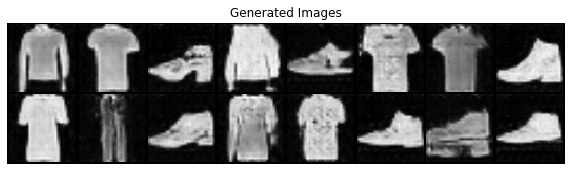

In [21]:
D = Discriminator().to(device)
G = Generator().to(device) 
D.apply(weights_init)
G.apply(weights_init)

if TRAINING_DATA:
    D_optimizer = torch.optim.Adam(D.parameters(), lr= 0.0002, betas=(0.5, 0.999))
    G_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5, 0.999))
    error = nn.BCELoss()
    G, D_loss_list, G_loss_list = train(D,G,D_optimizer,G_optimizer,error,trainloader)
else:
    G.load_state_dict(torch.load("model/generator-dcgan2.pth"))


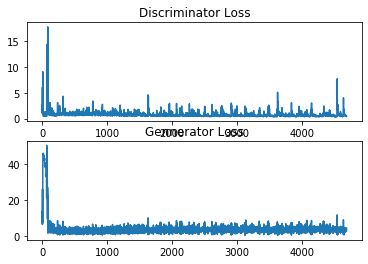

In [22]:
def plot(D_loss_list, G_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_loss_list)
    plt.subplot(2,1,1)
    plt.plot(range(EPOCHS), D_loss_list)
    plt.title("Discriminator Loss")
    plt.subplot(212)
    plt.plot(range(EPOCHS),G_loss_list)
    plt.title("Gennerator Loss")
    plt.show()
    
plot(D_loss_list, G_loss_list)

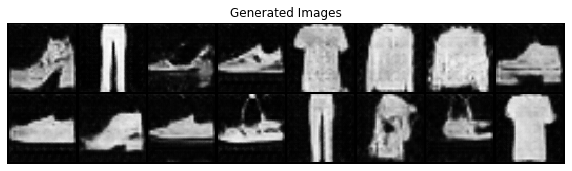

In [23]:
test_noise = f.random_noise(16)
generate_img(G,test_noise)